### Linear least squares optimization

In [1]:
import numpy as np
import perfplot
from numba import njit
from scipy import linalg
%load_ext snakeviz
%load_ext line_profiler

In [2]:
np.random.seed(42)

def generate_data(num_obs, num_indeps):
    x = np.random.randint(0, 10, (num_obs, num_indeps))
    x = np.hstack((np.ones((num_obs, 1)), x))
    e = np.random.randn(num_obs)
    beta = np.random.randint(0, 10, num_indeps + 1)

    y = x @ beta + e
    
    return y, x

In [3]:
@njit
def lu_factor(u):
    """
    
    Examples
    --------
    >>> a = np.array([
    ...     [0, 5, 5],
    ...     [2, 9, 0],
    ...     [6, 8, 8]
    ... ], dtype=float)
    >>> lu_factor(a)
    (array([[ 6.        ,  8.        ,  8.        ],
           [ 0.33333333,  6.33333333, -2.66666667],
           [ 0.        ,  0.78947368,  7.10526316]]), array([2, 1, 0], dtype=int64))
    """
    u = u * 1.0
    s = np.arange(u.shape[0])
    
    for i in range(u.shape[0] - 1):        
        row = np.argmax(np.abs(u[i:, i])) + i
        temp_row = u[row].copy()
        u[row] = u[i]
        u[i] = temp_row
        
        temp_s = s[row]
        s[row] = s[i]
        s[i] = temp_s

        for j in range(i + 1, u.shape[0]):
            u[j, i] = u[j, i] / u[i, i]
            u[j, i + 1:] = u[j, i + 1:] - u[j, i] * u[i, i + 1:]
            
    return u, s


@njit
def forward_substitution(l, b):
    """Solves Ly=b.
    
    L has to be a lower triangular matrix. It is not required that the diagonal
    has only elements of 1.
    
    References
    ----------
    - https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/INT-APP/CURVE-linear-system.html
    
    """
    y = np.zeros(b.shape[0])
    y[0] = b[0] / l[0, 0]
    for i in range(1, b.shape[0]):
        _sum = np.sum(l[i, :i] * y[:i])
        y[i] = (b[i] - _sum) / l[i, i]
    return y


@njit
def backward_substitution(u, y):
    """Solves Ux=y.
    
    References
    ----------
    - https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/INT-APP/CURVE-linear-system.html
    
    """
    x = np.zeros(y.shape[0])
    x[-1] = y[-1] / u[-1, -1]
    for i in range(y.shape[0] - 2, -1, -1):
        _sum = np.sum(u[i, i+1:] * x[i+1:])
        x[i] = (y[i] - _sum) / u[i, i]
            
    return x


@njit
def lu_solve(a, b):
    """Wrapper for lu_factor and forward, backward substitution.
    
    Example
    -------
    >>> a = np.array([[ 10.,  47.,  52.],
    ...               [ 47., 285., 229.],
    ...               [ 52., 229., 380.]])
    >>> b = np.array([ 600.37873965, 3022.99821901, 3815.80752727])
    >>> lu_solve(a, b)
    array([0.92718954, 4.82287129, 7.00830565])
    
    """
    lu, s = lu_factor(a)
    
    p = np.identity(s.shape[0])[s]
    l = np.tril(lu, k=-1) + np.identity(s.shape[0])
    u = np.triu(lu)
    
    y = forward_substitution(l, p.dot(b))
    x = backward_substitution(u, y)
    
    return x

@njit
def own_cholesky(A):
    """Performs a Cholesky decomposition of on symmetric, pos-def A.
    Returns lower-triangular L (full sized, zeroed above diag)
       
    References
    ----------
    - http://drsfenner.org/blog/2016/02/basic-cholesky-implementation/
    
    Examples
    --------
    >>> a = np.random.randint(0, 10, (4, 4))
    >>> a = a.T.dot(a)
    >>> x_1 = own_cholesky(a)
    >>> x_2 = np.linalg.cholesky(a)
    >>> assert np.allclose(x_1, x_2)
    
    """
    n = A.shape[0]
    L = np.zeros((n, n))

    # Perform the Cholesky decomposition
    for row in range(n):
        for col in range(row + 1):
            tmp_sum = L[row,:col].dot(L[col,:col])

            if (row == col): 
                # diag elts.
                L[row,col] = np.sqrt(A[row,row] - tmp_sum)
            else:
                # off-diag elts.
                L[row,col] = (1.0 / L[col,col] * (A[row,col] - tmp_sum))
                
#             L[row,col] = np.where(
#                 row == col,
#                 np.sqrt(A[row,row] - tmp_sum),
#                 1.0 / L[col,col] * (A[row,col] - tmp_sum)
#             )
    return L

In [7]:
@njit
def matrix_inversion(a):
    y, x = a[0], a[1]
    return np.linalg.inv(x.T.dot(x)).dot(x.T.dot(y))

@njit
def linalg_solve(a):
    y, x = a[0], a[1]
    
    return np.linalg.solve(x.T.dot(x), np.dot(x.T, y))

def lls_with_blas(z, residuals=False):
    """
    https://gist.github.com/aldro61/5889795
    """
    a, b = z[1], z[0]
    if type(a) != np.ndarray or not a.flags['C_CONTIGUOUS']:

        warn('Matrix a is not a C-contiguous numpy array. The solver will create a copy, which will result' + \
             ' in increased memory usage.')

    a = np.asarray(a, order='c')
    i = linalg.blas.dgemm(alpha=1.0, a=a.T, b=a.T, trans_b=True)
    
    return np.linalg.solve(i, linalg.blas.dgemm(alpha=1.0, a=a.T, b=b)).flatten()

def scipy_lu_solve(a):
    y, x = a[0], a[1]
    
    lu, piv = linalg.lu_factor(x.T @ x)
    return linalg.lu_solve((lu, piv), x.T @ y)


@njit
def own_lu_solve(a):
    y, x = a[0], a[1]
    
    return lu_solve(x.T.dot(x), x.T.dot(y))
    
    
@njit
def numpy_cholesky(a):
    y, x = a[0], a[1]
    l = np.linalg.cholesky(x.T.dot(x))
    
    c = forward_substitution(l, x.T.dot(y))
    
    return backward_substitution(l.T, c)

@njit
def own_chol(a):
    y, x = a[0], a[1]
    l = own_cholesky(x.T.dot(x))
    
    c = forward_substitution(l, x.T.dot(y))
    
    return backward_substitution(l.T, c)

@njit
def numpy_lstsq(a):
    y, x = a[0], a[1]
    
    return np.linalg.solve(x.T.dot(x), x.T.dot(y))

@njit
def numpy_qr(a):
    y, x = a[0], a[1]
    
    q, r = np.linalg.qr(x)
    
    return np.linalg.inv(r).dot(q.T.dot(y))

In [8]:
%%capture

out = perfplot.bench(
    setup=lambda n: generate_data(1000, n),
    kernels=[
        matrix_inversion, linalg_solve, lls_with_blas, scipy_lu_solve,
        numpy_cholesky, numpy_lstsq, numpy_qr, own_lu_solve, own_chol
    ],
    n_range=[2**k for k in range(10)],
    logx=True,
    logy=True,
    xlabel='Number of independent variables',
)

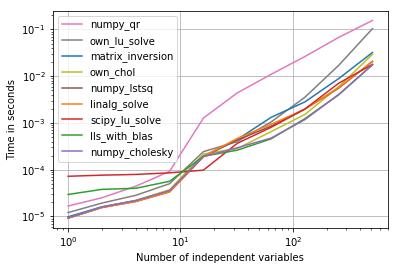

In [9]:
out.show()

### Other testing

In [ ]:
y, x = generate_data(10000, 1000)

a = x.T.dot(x)
b = x.T.dot(y)

#### My lu factor is too slow

In [ ]:
%%timeit
lu, s = lu_factor(a)

In [ ]:
%%timeit
lu, s = linalg.lu_factor(a)

#### My forward and backward substitution are awesome

In [ ]:
lu, s = lu_factor(a)

p = np.identity(s.shape[0])[s]
l = np.tril(lu, k=-1) + np.identity(s.shape[0])
u = np.triu(lu)

In [ ]:
%%timeit 

y = forward_substitution(l, p.dot(b))
x = backward_substitution(u, y)

In [ ]:
@njit
def numpy_for_back_subs(p, l, u, b):
    y = np.linalg.solve(l, p.dot(b))
    x = np.linalg.solve(u, y)

In [ ]:
%%timeit

numpy_for_back_subs(p, l, u, b)